# 🦜🕸️ LangGraph 기반 RAG 실습 (2025년 최신)

이번 실습에서는 **LangGraph**를 활용하여 RAG(Retrieval-Augmented Generation) 시스템을 구축해보겠습니다.

> 📢 **LangChain RAG vs LangGraph RAG**
> 
> - **LangChain RAG**는 체인 기반으로 순차적인 파이프라인을 구성합니다.
> - **LangGraph RAG**는 **그래프 기반 워크플로우**로 더 복잡한 로직과 조건부 분기를 구현할 수 있습니다.
> - LangGraph는 **상태(State) 관리**가 명확하여 디버깅과 확장이 용이합니다.


## 📋 목차

### Part A: Basic RAG
1. [환경 설정](#1-환경-설정)
2. [문서 로딩 및 벡터 스토어 생성](#2-문서-로딩-및-벡터-스토어-생성)
3. [RAG 체인 설정](#3-rag-체인-설정)
4. [LangGraph 상태 정의](#4-langgraph-상태-정의)
5. [그래프 노드 함수 정의](#5-그래프-노드-함수-정의)
6. [그래프 생성 및 컴파일](#6-그래프-생성-및-컴파일)
7. [그래프 시각화](#7-그래프-시각화)
8. [RAG 실행 테스트](#8-rag-실행-테스트)

### Part B: Agentic RAG (심화)
9. [Agentic RAG 개요](#9-agentic-rag-개요)
10. [웹 문서 전처리](#10-웹-문서-전처리)
11. [Retriever Tool 생성](#11-retriever-tool-생성)
12. [쿼리 생성 또는 응답](#12-쿼리-생성-또는-응답)
13. [문서 관련성 평가](#13-문서-관련성-평가)
14. [질문 재작성](#14-질문-재작성)
15. [답변 생성](#15-답변-생성)
16. [Agentic RAG 그래프 조립](#16-agentic-rag-그래프-조립)
17. [Agentic RAG 실행](#17-agentic-rag-실행)


---
## 1. 환경 설정

먼저 필요한 패키지들을 설치하고 환경을 구성합니다.


In [ ]:

%pip install -qU langchain langchain-openai langchain-community langgraph langchain-mcp-adapters mcp chromadb tiktoken bs4

In [2]:
# 환경 변수 설정
import os
from dotenv import load_dotenv

load_dotenv()

# OpenAI API 키 설정 (환경 변수에 없으면 직접 입력)
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = "your-openai-api-key"

---
## 2. 문서 로딩 및 벡터 스토어 생성

PDF 문서를 로드하고, 텍스트를 청크로 분할한 뒤 ChromaDB 벡터 스토어에 저장합니다.

### 주요 컴포넌트:
- **PyPDFLoader**: PDF 문서 로딩
- **RecursiveCharacterTextSplitter**: 텍스트 청크 분할 (tiktoken 인코더 사용)
- **Chroma**: 벡터 저장소 (로컬 인메모리)


In [3]:
# 문서 로드 및 벡터 스토어 생성
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# 임베딩 모델 설정
embeddings = OpenAIEmbeddings()

# PDF 파일 경로 설정 (OpenAI RAG 실습과 동일한 문서 사용)
file_path = "docs/DeepSeek_OCR_paper.pdf"

# PDF 로더 초기화 및 문서 로드
loader = PyPDFLoader(file_path)
docs = loader.load()

print(f"📄 로드된 문서 수: {len(docs)} 페이지")

# 문서 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, 
    chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs)

print(f"총 {len(doc_splits)}개의 문서 청크 생성됨")

# 벡터 스토어 생성
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

# 리트리버 생성
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})


📄 로드된 문서 수: 22 페이지
총 46개의 문서 청크 생성됨


---
## 3. RAG 체인 설정

LLM 모델과 프롬프트 템플릿을 설정하고, 기본 RAG 체인을 구성합니다.


In [4]:
# RAG 체인 설정
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LLM 모델 설정
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

# RAG 프롬프트 가져오기

prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
     Use three sentences maximum and keep the answer concise. Answer in Korean"""),
    ("human", "Question: {question}\n\nContext: {context}\n\nAnswer:")
])

# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()


---
## 4. LangGraph 상태 정의

LangGraph에서 사용할 **상태(State)**를 정의합니다. 상태는 그래프의 각 노드 간에 전달되는 데이터 구조입니다.

### GraphState 구성:
- `question`: 사용자 질문
- `documents`: 검색된 문서 리스트
- `generation`: 생성된 답변


In [5]:
# LangGraph 상태 정의
from typing import TypedDict, List, Annotated
from langchain_core.documents import Document
import operator

class GraphState(TypedDict):
    """RAG 그래프의 상태를 정의"""
    question: str
    documents: List[Document]
    generation: str


---
## 5. 그래프 노드 함수 정의

RAG 워크플로우를 구성하는 **노드(Node)** 함수들을 정의합니다.

### 노드 설명:
- **retrieve**: 질문을 받아 관련 문서를 검색하는 노드
- **generate**: 검색된 문서를 바탕으로 답변을 생성하는 노드


In [6]:

# 그래프 노드 함수 정의
def retrieve(state: GraphState) -> GraphState:
    """문서 검색 노드"""
    print("---RETRIEVE---")
    question = state["question"]
    
    # 리트리버를 사용해 관련 문서 검색
    documents = retriever.invoke(question)
    
    return {"question": question, "documents": documents, "generation": ""}


def generate(state: GraphState) -> GraphState:
    """답변 생성 노드"""
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # 문서를 텍스트로 포맷팅
    docs_txt = format_docs(documents)
    
    # RAG 체인을 사용해 답변 생성
    generation = rag_chain.invoke({"context": docs_txt, "question": question})
    
    return {"question": question, "documents": documents, "generation": generation}

---
## 6. 그래프 생성 및 컴파일

노드들을 연결하여 **StateGraph**를 생성하고 컴파일합니다.

### 그래프 구조:
```
START → retrieve → generate → END
```

이 단순한 구조가 기본 RAG의 핵심입니다. LangGraph를 사용하면 이후에 조건부 분기, 루프 등 복잡한 로직을 쉽게 추가할 수 있습니다.


In [7]:

# LangGraph 그래프 생성 및 컴파일
from langgraph.graph import StateGraph, START, END

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)

# 엣지 연결
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile()

print("RAG 그래프가 성공적으로 컴파일되었습니다.")

RAG 그래프가 성공적으로 컴파일되었습니다.


---
## 7. 그래프 시각화

컴파일된 그래프를 시각화하여 워크플로우를 확인합니다.


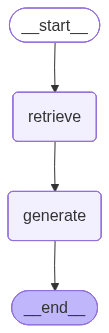

In [8]:
# 그래프 시각화
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"시각화 오류: {e}")
    print("그래프 구조: START -> retrieve -> generate -> END")

---
## 8. RAG 실행 테스트

구축한 RAG 그래프를 실행하여 질의응답을 테스트합니다.

### 테스트 방법:
1. **invoke()**: 동기 실행 - 전체 결과를 한 번에 반환
2. **stream()**: 스트리밍 실행 - 각 노드 실행 결과를 순차적으로 반환


In [9]:
# RAG 그래프 실행 테스트
question = "Deepseek OCR이 뭐야?"

# 그래프 실행
result = app.invoke({"question": question})

print("=" * 50)
print(f"질문: {result['question']}")
print("=" * 50)
print(f"\n답변:\n{result['generation']}")
print("=" * 50)
print(f"\n참조 문서 수: {len(result['documents'])}")

---RETRIEVE---
---GENERATE---
질문: Deepseek OCR이 뭐야?

답변:
DeepSeek OCR은 대규모 사전학습 데이터 생산이 가능한 실용적인 OCR 모델로, 약 100개 언어의 PDF 문서 처리를 지원합니다. 높은 정확도와 적은 비전 토큰 수로 최첨단 성능을 보여주며, LLM(대형 언어 모델)의 필수 보조 도구로 활용됩니다. 또한 일반 이미지 이해 능력도 갖추고 있습니다.

참조 문서 수: 3


In [10]:
# 스트리밍 방식으로 실행
question = "Omnidoc bench 결과는 어때?"

print(f"질문: {question}\n")
print("=" * 50)

for output in app.stream({"question": question}):
    for node_name, value in output.items():
        print(f"\n[{node_name}] 노드 실행 완료")
        if node_name == "generate" and "generation" in value:
            print(f"\n답변:\n{value['generation']}")


질문: Omnidoc bench 결과는 어때?

---RETRIEVE---

[retrieve] 노드 실행 완료
---GENERATE---

[generate] 노드 실행 완료

답변:
OmniDocBench 결과에서 DeepSeek-OCR은 100개의 비전 토큰만으로도 GOT-OCR2.0보다 우수한 성능을 보이며, 400 토큰 사용 시 최첨단 성능과 동등한 결과를 나타냅니다. 또한, DeepSeek-OCR은 적은 비전 토큰 수로도 높은 정확도(편집 거리 ED < 0.25)를 달성하여 효율적이고 실용적인 OCR 모델임을 입증했습니다. 전반적으로 OmniDocBench에서 DeepSeek-OCR은 최첨단 성능을 보이며 토큰 수가 가장 적은 모델 중 하나입니다.


### 💡 LangGraph RAG의 장점

1. **명확한 상태 관리**: TypedDict로 상태를 정의하여 타입 안정성 확보
2. **확장성**: 조건부 라우팅, 루프 등 복잡한 워크플로우 구현 가능
3. **디버깅 용이**: 각 노드의 입출력을 명확하게 추적 가능
4. **시각화**: 그래프 구조를 시각적으로 확인 가능

---
## 📚 참고 자료

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)


# ![Langgraph Hybrid RAG Tutorial](https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/langgraph-hybrid-rag-tutorial.png?w=840&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=b7626e6ae3cb94fb90a61e6fad69c8ba)

---
# 🤖 Part B: Agentic RAG 구현

## 9. Agentic RAG 개요

이제 더 발전된 형태의 **Agentic RAG**를 구현해보겠습니다.

### Agentic RAG란?
LLM 에이전트가 **검색 여부와 방법을 스스로 결정**하는 RAG 시스템입니다.

### 주요 특징:
- LLM이 retriever tool 호출 여부를 **자율적으로 판단**
- 검색된 문서의 **관련성을 평가**하고 필요시 질문을 재작성
- 조건부 분기와 루프를 통한 **자기 개선** 가능

### 그래프 구조:
```
START → generate_query_or_respond → [tool 호출?]
                                      ├─ Yes → retrieve → [관련성?]
                                      │                     ├─ Yes → generate_answer → END
                                      │                     └─ No → rewrite_question ─┘
                                      └─ No → END (직접 응답)
```

![Agentic RAG](https://docs.langchain.com/oss/images/agentic-rag-output.png)


---
## 10. 문서 전처리

In [ ]:
# PDF 문서 로딩
from langchain_community.document_loaders import PyPDFLoader

pdf_path = "docs/DeepSeek_OCR_paper.pdf"

pdf_loader = PyPDFLoader(pdf_path)
docs = [pdf_loader.load()]
print(f"📄 PDF 문서 로드 완료")


📄 PDF 문서 로드 완료


In [14]:
from langchain_core.vectorstores import InMemoryVectorStore

# 문서 분할 및 벡터 스토어 생성
docs_list = [item for sublist in web_docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

print(f"✂️ 총 {len(doc_splits)}개의 청크 생성")

# 인메모리 벡터 스토어 생성

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, 
    embedding=OpenAIEmbeddings()
)
web_retriever = vectorstore.as_retriever()
print("✅ 웹 문서 벡터 스토어 생성 완료")


✂️ 총 27개의 청크 생성
✅ 웹 문서 벡터 스토어 생성 완료


---
## 11. Retriever Tool 생성

`@tool` 데코레이터를 사용하여 검색 도구를 생성합니다. 에이전트가 이 도구를 호출하여 문서를 검색합니다.


In [20]:
from langchain.tools import tool

@tool
def retrieve(query: str) -> str:
    """DeepSeek OCR 논문에서 관련 정보를 검색합니다."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_tool = retrieve
print("✅ Retriever Tool 생성 완료")


✅ Retriever Tool 생성 완료


In [21]:
# 도구 테스트
retriever_tool.run({"query": "deepseek ocr 모델"})


'tionally, DeepSeek-OCR is a highly practical model capable of large-scale pretraining data\nproduction, serving as an indispensable assistant for LLMs. Of course, OCR alone is insufficient\nto fully validate true context optical compression and we will conduct digital-optical text in-\nterleaved pretraining, needle-in-a-haystack testing, and other evaluations in the future. From\nanother perspective, optical contexts compression still offers substantial room for research and\nimprovement, representing a promising new direction.\n19\n\nSmolDocling\nGOT-OCR2.0\nDeepSeek-OCR (Tiny)\nDeepSeek-OCR (Small)\nDeepSeek-OCR (Base)\nDeepSeek-OCR (Large)\nDeepSeek-OCR (Gundam)\nVision T okens < 1000 \n Average per image (  Fewer)\nHigh Accuracy \n ED < 0.25 (  better)\nAverage Vision T okens per Image (b) Performance on Omnidocbench\nFigure 1 |Figure (a) shows the compression ratio (number of text tokens in ground truth/number\nof vision tokens model used) testing on Fox [ 21] benchmark; Figure (

---
## 12. 쿼리 생성 또는 응답

`generate_query_or_respond` 노드는 LLM이 사용자 질문을 보고 **검색이 필요한지 판단**합니다.
- 검색이 필요하면 → retriever tool 호출
- 필요 없으면 → 직접 응답


In [ ]:
from langgraph.graph import MessagesState

response_model = ChatOpenAI("gpt-4.1-mini", temperature=0)

def generate_query_or_respond(state: MessagesState):
    """LLM이 검색 여부를 판단하여 tool 호출 또는 직접 응답"""
    response = (
        response_model
        .bind_tools([retriever_tool])
        .invoke(state["messages"])
    )
    return {"messages": [response]}

print("✅ generate_query_or_respond 노드 정의 완료")


✅ generate_query_or_respond 노드 정의 완료


In [23]:
# 테스트: 일반 인사 (검색 불필요)
test_input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(test_input)["messages"][-1].pretty_print()


================================== Ai Message ==================================

Hello! How can I assist you today?


In [25]:
# 테스트: 검색이 필요한 질문 (Tool Call 발생)
test_input = {"messages": [{"role": "user", "content": "DeepEncoder란?"}]}
generate_query_or_respond(test_input)["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  retrieve (call_QlI2mW049AuXKv9JO0oBaitD)
 Call ID: call_QlI2mW049AuXKv9JO0oBaitD
  Args:
    query: DeepEncoder


---
## 13. 문서 관련성 평가

검색된 문서가 질문과 **관련이 있는지 평가**하는 조건부 엣지입니다.


In [ ]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question.\n"
    "Here is the retrieved document:\n\n{context}\n\n"
    "Here is the user question: {question}\n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.\n"
    "Give a binary score 'yes' or 'no' to indicate whether the document is relevant."
)

class GradeDocuments(BaseModel):
    """문서 관련성 평가를 위한 이진 점수"""
    binary_score: str = Field(description="Relevance score: 'yes' or 'no'")

grader_model = ChatOpenAI("gpt-4o-mini", temperature=0)

def grade_documents(state: MessagesState) -> Literal["generate_answer", "rewrite_question"]:
    """검색된 문서의 관련성을 평가"""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = grader_model.with_structured_output(GradeDocuments).invoke(
        [{"role": "user", "content": prompt}]
    )
    
    if response.binary_score == "yes":
        print("---GRADE: 관련 있음---")
        return "generate_answer"
    else:
        print("---GRADE: 관련 없음 → 질문 재작성---")
        return "rewrite_question"

print("✅ grade_documents 조건부 엣지 정의 완료")


✅ grade_documents 조건부 엣지 정의 완료


---
## 14. 질문 재작성

검색 결과가 관련 없을 경우, **질문을 개선**하여 다시 검색합니다.


In [27]:
from langchain_core.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:\n---\n{question}\n---\n"
    "Formulate an improved question:"
)

def rewrite_question(state: MessagesState):
    """질문을 재작성"""
    print("---REWRITE QUESTION---")
    question = state["messages"][0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

print("✅ rewrite_question 노드 정의 완료")


✅ rewrite_question 노드 정의 완료


In [28]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question}\nContext: {context}"
)

def generate_answer(state: MessagesState):
    """최종 답변 생성"""
    print("---GENERATE ANSWER---")
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

print("✅ generate_answer 노드 정의 완료")


✅ generate_answer 노드 정의 완료


---
## 16. Agentic RAG 그래프 조립

모든 노드와 엣지를 연결하여 **완전한 Agentic RAG 그래프**를 생성합니다.


In [29]:
from langgraph.prebuilt import ToolNode, tools_condition

# Agentic RAG 그래프 생성
agentic_workflow = StateGraph(MessagesState)

# 노드 추가
agentic_workflow.add_node(generate_query_or_respond)
agentic_workflow.add_node("retrieve", ToolNode([retriever_tool]))
agentic_workflow.add_node(rewrite_question)
agentic_workflow.add_node(generate_answer)

# 시작 엣지
agentic_workflow.add_edge(START, "generate_query_or_respond")

# 조건부 엣지: Tool 호출 여부 판단
agentic_workflow.add_conditional_edges(
    "generate_query_or_respond",
    tools_condition,
    {"tools": "retrieve", END: END}
)

# 조건부 엣지: 문서 관련성 평가
agentic_workflow.add_conditional_edges("retrieve", grade_documents)

# 일반 엣지
agentic_workflow.add_edge("generate_answer", END)
agentic_workflow.add_edge("rewrite_question", "generate_query_or_respond")

# 컴파일
agentic_graph = agentic_workflow.compile()
print("✅ Agentic RAG 그래프 컴파일 완료!")


✅ Agentic RAG 그래프 컴파일 완료!


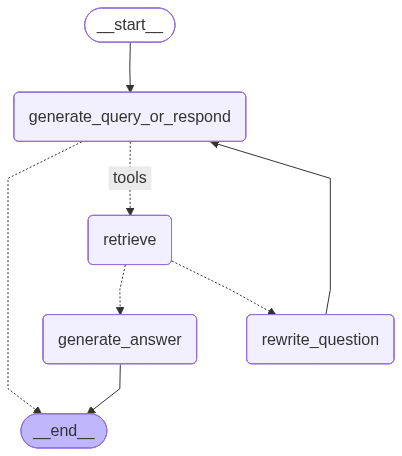

In [30]:
# Agentic RAG 그래프 시각화
try:
    display(Image(agentic_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"시각화 오류: {e}")


---
## 17. Agentic RAG 실행

완성된 Agentic RAG 그래프를 실행하여 질의응답을 테스트합니다.


In [32]:
# Agentic RAG 실행 테스트
for chunk in agentic_graph.stream(
    {"messages": [{"role": "user", "content": "DeepSeek OCR이 뭐야?"}]}
):
    for node, update in chunk.items():
        print(f"\n🔄 Update from node: {node}")
        update["messages"][-1].pretty_print()



🔄 Update from node: generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_bTfdzOQeY7gDGZOp7cse7mQm)
 Call ID: call_bTfdzOQeY7gDGZOp7cse7mQm
  Args:
    query: DeepSeek OCR
---GRADE: 관련 있음---

🔄 Update from node: retrieve
================================= Tool Message =================================
Name: retrieve

tionally, DeepSeek-OCR is a highly practical model capable of large-scale pretraining data
production, serving as an indispensable assistant for LLMs. Of course, OCR alone is insufficient
to fully validate true context optical compression and we will conduct digital-optical text in-
terleaved pretraining, needle-in-a-haystack testing, and other evaluations in the future. From
another perspective, optical contexts compression still offers substantial room for research and
improvement, representing a promising new direction.
19

DeepSeek-OCR: Contexts Optical Compression
Haoran Wei, Yaofeng Sun